# CODE TAKEN FROM https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb#scrollTo=U-5ZGq5UZ5QK

In [1]:
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost_rebase'

In [2]:
import enum
import time
import random
import multiprocessing
from pathlib import Path
import pandas as pd
import torch
import torchvision
import torchio as tio
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt
import copy

from IPython import display
from tqdm.auto import tqdm

In [3]:
num_workers = 2
plt.rcParams['figure.figsize'] = 12, 6

In [4]:
dataset_dir = Path('/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl/data/IXITiny')
images_dir = dataset_dir / 'image'
labels_dir = dataset_dir / 'label'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        brain=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 566 subjects


In [5]:

training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.RandomMotion(p=0.2),
    tio.RandomBiasField(p=0.3),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.OneHot(),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 509 subjects
Validation set: 57 subjects


In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['mri'][tio.DATA].to(device)
    targets = batch['brain'][tio.DATA].to(device)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs.float())
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

In [7]:
training_batch_size = 1
validation_batch_size = training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=num_workers,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=num_workers,
)

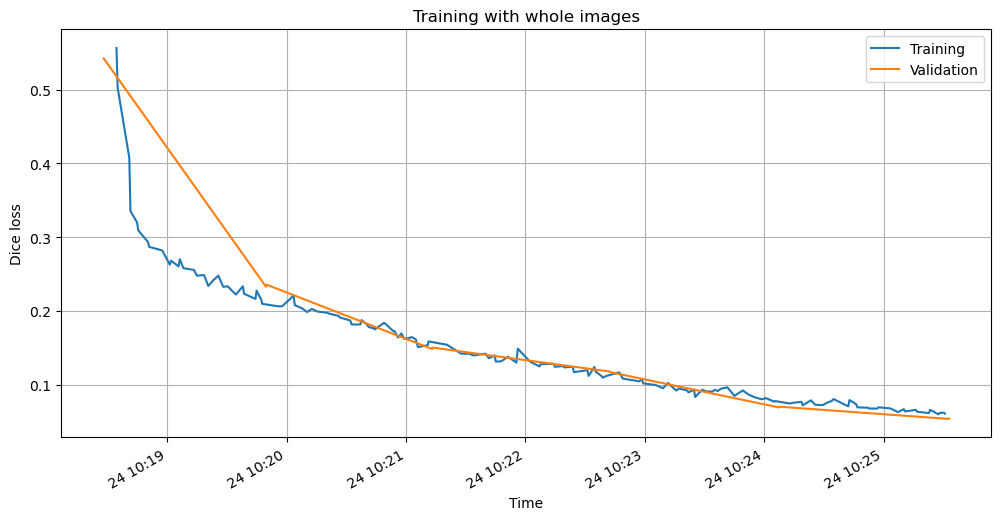

In [8]:
model, optimizer = get_model_and_optimizer(device)
weights_path = 'whole_image_state_dict.pth'
if train_whole_images:
    weights_stem = 'whole_images'
    train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)
else:
    weights_path = 'whole_image_state_dict.pth'
    weights_url = 'https://github.com/TorchIO-project/torchio-data/raw/main/models/whole_images_epoch_5.pth'
    !curl --location --silent --output {weights_path} {weights_url}
    checkpoint = torch.load(weights_path, map_location=device)
    model.load_state_dict(checkpoint['weights'])
    train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']

def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)
    
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with whole images')
ax.legend()
fig.autofmt_xdate()

# Add flattening layers to bottleneck

In [151]:
class Autoencoder(nn.Module):
    def __init__(self, n_emb):
        super(Autoencoder, self).__init__()
        self.n_emb = n_emb
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 2 * 2 * 2, self.n_emb),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.n_emb, 32 * 2 * 2 * 2),
            nn.ReLU(),
            nn.Unflatten(1, (32, 2, 2, 2)),
            nn.ConvTranspose3d(32, 64, kernel_size=(2,3,2), stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=(3,2,3), stride=2, padding=1, output_padding=1) # Changed the kernel size in the Y dimension
        )

    def forward(self, x, embedding = False):
        x = self.encoder(x)
        if embedding:
            return x
        x = self.decoder(x)
        return x


In [162]:
model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    )
n_emb = 4048
ae = Autoencoder(n_emb)
criterion = get_dice_loss
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

In [163]:
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4
with torch.no_grad():
        skip_connections, encoding = model.encoder(input_tensor.float())
        encoding = model.bottom_block(encoding)

encoding_ = ae(encoding, embedding = False)
with torch.no_grad():
        x = model.decoder(skip_connections, encoding_)
        logits = model.classifier(x)
probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
losses = criterion(input_tensor.float(), probabilities)
losses.mean()

optimizer.zero_grad()
losses.backward()
optimizer.step()

tensor([[ 0.0507, -0.0425]])

## Full code

In [8]:
global ROOT_DIR
ROOT_DIR = '/gpfs/commons/groups/gursoy_lab/aelhussein/ot_cost/otcost_fl'
EPOCHS = 1000
BATCH_SIZE = 8
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def load_data():
    training_split_ratio = 0.9
    dataset_dir = Path(f'{ROOT_DIR}/data/IXITiny')
    images_dir = dataset_dir / 'image'
    labels_dir = dataset_dir / 'label'
    image_paths = sorted(images_dir.glob('*.nii.gz'))
    label_paths = sorted(labels_dir.glob('*.nii.gz'))

    subjects = []
    for (image_path, label_path) in zip(image_paths, label_paths):
        subject = tio.Subject(
            mri=tio.ScalarImage(image_path),
            brain=tio.LabelMap(label_path),
        )
        subjects.append(subject)
    dataset = tio.SubjectsDataset(subjects)
    training_transform = tio.Compose([
        tio.ToCanonical(),
        tio.Resample(4),
        tio.CropOrPad((48, 60, 48)),
        tio.RandomMotion(p=0.2),
        tio.RandomBiasField(p=0.3),
        tio.RandomNoise(p=0.5),
        tio.RandomFlip(),
        tio.OneOf({
            tio.RandomAffine(): 0.8,
            tio.RandomElasticDeformation(): 0.2,
        }),
        tio.OneHot(),
    ])

    validation_transform = tio.Compose([
        tio.ToCanonical(),
        tio.Resample(4),
        tio.CropOrPad((48, 60, 48)),
        tio.OneHot(),
    ])

    num_subjects = len(dataset)
    num_training_subjects = int(training_split_ratio * num_subjects)
    num_validation_subjects = num_subjects - num_training_subjects

    num_split_subjects = num_training_subjects, num_validation_subjects
    training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

    training_set = tio.SubjectsDataset(
        training_subjects, transform=training_transform)

    validation_set = tio.SubjectsDataset(
        validation_subjects, transform=validation_transform)

    training_batch_size = 8
    validation_batch_size = training_batch_size

    train_loader = torch.utils.data.DataLoader(
        training_set,
        batch_size=training_batch_size,
        shuffle=True,
    )

    val_loader = torch.utils.data.DataLoader(
        validation_set,
        batch_size=validation_batch_size,
        )

    return train_loader, val_loader

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, n_emb):
        super(Autoencoder, self).__init__()
        self.n_emb = n_emb
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv3d(64, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 2 * 2 * 2, self.n_emb),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(self.n_emb, 32 * 2 * 2 * 2),
            nn.ReLU(),
            nn.Unflatten(1, (32, 2, 2, 2)),
            nn.ConvTranspose3d(32, 64, kernel_size=(2,3,2), stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=(3,2,3), stride=2, padding=1, output_padding=1) # Changed the kernel size in the Y dimension
        )

    def forward(self, x, embedding = False):
        x = self.encoder(x)
        if embedding:
            return x
        x = self.decoder(x)
        return x


In [ ]:
def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

In [9]:
def train_autoencoder(n_emb):
    # Initialize
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    )
    model.to(DEVICE)
    ae = Autoencoder(n_emb)
    ae = ae.to(DEVICE)
    criterion = get_dice_loss
    optimizer = torch.optim.Adam(ae.parameters(), lr=LR)
    
    # Load data
    train_loader, val_loader = load_data()
    # Early stopping parameters
    patience = 10
    early_stopping_counter = 0
    best_val_loss = float('inf')

    # Loss tracking
    train_losses = []
    val_losses = []

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        ae.train()
        
        # Training step
        train_loss = 0.0
        for input_tensor in train_loader:
            image = input_tensor['mri']['data'].float()
            image = image.to(DEVICE) 
            optimizer.zero_grad()
            with torch.no_grad():
                skip_connections, encoding = model.encoder(image)
                encoding = model.bottom_block(encoding)

            encoding_ = ae(encoding, embedding=False)
            with torch.no_grad():
                x = model.decoder(skip_connections, encoding_)
                logits = model.classifier(x)
            
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            losses = criterion(image, probabilities)
            loss = losses.mean()
            loss.backward()
            optimizer.step()
            train_loss += loss.item().detach().cpu()
            
        train_losses.append(train_loss / len(train_loader))
        
        # Validation step
        model.eval()
        ae.eval()
        
        val_loss = 0.0
        with torch.no_grad():
            for input_tensor in val_loader:
                image = input_tensor['mri']['data'].float()
                image = image.to(DEVICE)
                skip_connections, encoding = model.encoder(image)
                encoding = model.bottom_block(encoding)
                encoding_ = ae(encoding, embedding=False)
                x = model.decoder(skip_connections, encoding_)
                logits = model.classifier(x)
                
                probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
                losses = criterion(image, probabilities)
                val_loss += losses.mean().item().detach().cpu()
                
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch}, Train Loss: {train_loss / len(train_loader)}, Validation Loss: {val_loss}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_model = copy.deepcopy(ae)
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping")
                break
    
    best_model.to('cpu')
    torch.save(best_model.state_dict(), f'{ROOT_DIR}/data/IXITiny/model_checkpoint_{n_emb}.pth')
    return train_losses, val_losses




In [ ]:

def main():
    print(DEVICE)

    n_embs = [2048]
    losses = {}
    for n_emb in n_embs:
        losses[n_emb] = train_autoencoder(n_emb)
    with open(f'{ROOT_DIR}/data/IXITiny/losses.json', 'w') as f:
        json.dump(losses, f)
    print("Losses saved to file.")

if __name__ == '__main__':
    main()
    